In [100]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
 
img_width, img_height = 128, 128

input_shape = (img_width, img_height, 3) ## we checked that the RGB channel comes last in the data format of these images

epochs = 10
batch_size = 16

### Creating the model (convolutional neural net)

In [103]:
model = Sequential() 

# first convolutional layer 
model.add(Conv2D(32, (4, 4), activation = 'relu', input_shape = input_shape)) ## convolution of kernel with image
model.add(MaxPooling2D(pool_size=(2, 2))) ## reduces dimensionality in order to reduce computational cost + minimize overfitting

# second convolutional layer
model.add(Conv2D(32, (4, 4), activation = 'relu'))  ## convolution of kernel with image
model.add(MaxPooling2D(pool_size=(2, 2)))  ## reduces dimensionality in order to reduce computational cost + minimize overfitting
 
# third convolutional layer
model.add(Conv2D(64, (4, 4), activation = 'relu'))  ## convolution of kernel with image
model.add(MaxPooling2D(pool_size=(2, 2)))  ## reduces dimensionality in order to reduce computational cost + minimize overfitting

model.add(Flatten()) ## transitions from convolutional to fully connected layers by converting the input from multi-dimensional --> 1D

# first densely-connected layer 
model.add(Dense(64, activation = 'relu')) ## creates a fully connected layer with 64 output units (neurons)
model.add(Dropout(0.2)) ## this function randomly sets 20% of the input units to 0 at each training step; used to prevent overfitting

# second densely-connected layer 
model.add(Dense(16, activation = 'relu')) ## creates a fully connected layer with 16 output units (neurons)
model.add(Dropout(0.2)) ## this function randomly sets 20% of the input units to 0 at each training step; used to prevent overfitting

# third densely-connected layer 
model.add(Dense(4, activation = 'sigmoid')) ## creates a fully connected layer with 4 output units (neurons) corresponding to the 4 output classes

model.compile(loss = 'binary_crossentropy',
              optimizer = 'nadam',
              metrics = ['accuracy']) ## will optimize for accuracy even though the data is imbalanced; will need to check that the model is not underpredicting the minority class

NOTE: We experimented with the number of epochs, batch size, number of layers, neurons per layer, and number/ratio of dropout functions to determine approximately the best model (according to best validation performance). We also experimented with three types of optimizers: adagrad, rmsprop, and nadam. The rmsprop and nadam optimizers seemed to provide the best model accuracy.

### Building the model (training on train data and building it to maximize accuracy on validation data)

In [105]:
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, vertical_flip=True, rescale=1/255) 
## this is the data augmentor that we will use to try to improve model accuracy, with the range of parameters/allowed modifications it can perform on each image

train_data = datagen.flow_from_directory(
    directory = r'C:\Users\lucia\OneDrive - University of Calgary\University\Year 3\Semester 2\Bmen 415\Coursework\Course Project\GitHub\BMEN-415\Data\_split datasets\image train_test_val split\train',
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    seed = 112)
 
validation_data = datagen.flow_from_directory(
    r'C:\Users\lucia\OneDrive - University of Calgary\University\Year 3\Semester 2\Bmen 415\Coursework\Course Project\GitHub\BMEN-415\Data\_split datasets\image train_test_val split\val',
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    seed = 112)
 
training = model.fit(
            train_data,
            steps_per_epoch = 4487 // (batch_size),
            epochs = epochs,
            validation_data = validation_data,
            validation_steps = 642 // (batch_size))

# removed class weights since these seem to decrease model performance
# class_weight = {0: 4487/627, 1: 4487/44, 2: 4487/2240, 3: 4487/1568}) ## these class weights are based on the train dataset (total train samples/train samples for class i)

Found 4487 images belonging to 4 classes.
Found 642 images belonging to 4 classes.
Epoch 1/10
280/280 [==============================] - 143s 509ms/step - loss: 0.4529 - accuracy: 0.4945 - val_loss: 0.4328 - val_accuracy: 0.4969
Epoch 2/10
280/280 [==============================] - 168s 598ms/step - loss: 0.4327 - accuracy: 0.5193 - val_loss: 0.4151 - val_accuracy: 0.5156
Epoch 3/10
280/280 [==============================] - 184s 655ms/step - loss: 0.4242 - accuracy: 0.5363 - val_loss: 0.4334 - val_accuracy: 0.5375
Epoch 4/10
280/280 [==============================] - 161s 575ms/step - loss: 0.4188 - accuracy: 0.5524 - val_loss: 0.3986 - val_accuracy: 0.5609
Epoch 5/10
280/280 [==============================] - 138s 491ms/step - loss: 0.4138 - accuracy: 0.5529 - val_loss: 0.3903 - val_accuracy: 0.5641
Epoch 6/10
280/280 [==============================] - 152s 544ms/step - loss: 0.4064 - accuracy: 0.5636 - val_loss: 0.3875 - val_accuracy: 0.5688
Epoch 7/10
280/280 [=====================

In [106]:
model.save('CNN_model.h5')

### Testing the model (on completely reserved test data)

In [108]:
from keras.models import load_model

test_data = tf.keras.utils.image_dataset_from_directory(
    r'C:\Users\lucia\OneDrive - University of Calgary\University\Year 3\Semester 2\Bmen 415\Coursework\Course Project\GitHub\BMEN-415\Data\_split datasets\image train_test_val split\test',
    image_size = (img_width, img_height),
    batch_size = batch_size,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented'],
    seed = 112)

# Load trained Keras model
model = load_model('CNN_model.h5')

# Evaluate model on test data
loss, accuracy = model.evaluate(test_data)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Found 1279 files belonging to 4 classes.
80/80 [==============================] - 7s 77ms/step - loss: 74.8607 - accuracy: 0.5082
Test loss: 74.8607406616211
Test accuracy: 0.5082095265388489


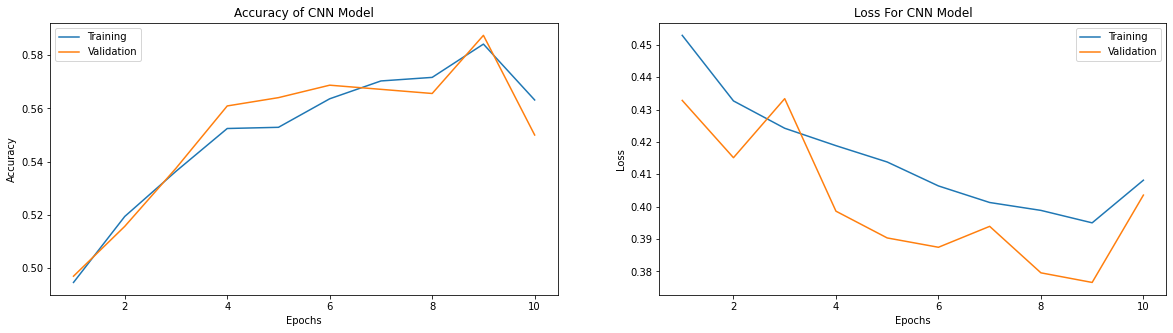

In [109]:
import matplotlib.pyplot as plt

accuracy = training.history['accuracy']
val_accuracy = training.history['val_accuracy']
loss = training.history['loss']
val_loss = training.history['val_loss']

plt.figure(figsize = (20, 5))

plt.subplot(1, 2, 1)
plt.title('Accuracy of CNN Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(range(1, 11), accuracy, label = 'Training')
plt.plot(range(1, 11), val_accuracy, label = 'Validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss For CNN Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(1, 11), loss, label = 'Training')
plt.plot(range(1, 11), val_loss, label = 'Validation')
plt.legend()

plt.show()